# Tutorial on ebcpy

Assume the following situation.
From an experiment we have gathered following data:
<img src="data/measured_data.png">
We want to use the data as an input to a simulation. However, as visible, the data is noisy and thus may lead to instability of our simulation.

First we will load modules supporting this tutorial. Note that you should install matplotlib first if not already happenend, as only this tutorial needs matplotlib. For usage of ebcpy, you don't need it.

In [1]:
import os
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Types
Let's specify the path to our measurement data and load it.    

In [ ]:
from ebcpy import data_types
# Specify the path to the measured data:
path = os.path.join(os.getcwd(), "data", "measuredData.hdf")
try:
    data_types.TimeSeriesData(path)
except KeyError as e:
    print(e)

**Why did we expect the error?** One hdf-file can store multiple tables.
In this case, 'other test' was stored as-well.

The error shows the options you have, 'other test' or 'test'.
Same applies for other file-formats. '.csv' needs the seperator (`sep`),
and '.xlsx' the name of the sheet (`sheet_name`) as a keyword-argument.

'test' holds in this case the correct data:

In [ ]:
tsd = data_types.TimeSeriesData(path, key="test")
print(tsd)
plt.plot(tsd["measured_T"])
plt.title("1: Measured data")
plt.show()

If you're familiar with `python` and `DataFrames`, you will ask  yourself: **Why do I need the TimeSeriesData-Class?** We implemented this class to combine the powerful `pandas.DataFrame` class with new functions for an easy usage in the context of Building Energy Systems for three main reasons:
- Most data in our case is Time-Dependend, therefore functions for easy conversion between seconds (for Simulation) and Timestamps (for measurements) is needed 
- Most data is stored in files. Typically .hdf and .mat is used, .csv and even .xlsx files occur frequently. Pandas has different functions (`from_hdf`, `from_csv`) and no at all function for loading Modelica-Result files.
- Working with energy related data, you most likely are interested in understanding where a value comes from. For this reason we base the TimeSeriesData-Class on the pandas MultiColumn-Feature. Every variable (e.g. Temperature) will get tags for specific reasons. The default being "raw", assuming that data loaded from a file without tags most likely is unprocessed.

Note how the loaded measurement got the tag 'raw'. Else not much new, just DataFrame. Let's adjust the noisy data for the usage in a simulation tool like Modelica.

For this reason, we load the preprocessing module of `ebcpy`. 

# Preprocessing

We want to manipulate only the values in the DataFrame. Therefore we need to first extract the data. We use numpy as a return type, as most preprocessing functions like filters run on numpy-arrays. 

In [ ]:
from ebcpy import preprocessing
# Extract the column of interest to get the trajectory or array for processing
trajectory = tsd.get_columns_by_tag("raw", columns=["measured_T"], return_type="numpy")
print(trajectory)

We then can apply either a filter or a moving-average. To further understand differences between both options, adjust the parameters in the box below and rerun the cell. You will see how the output changes. Which function you use for your data is up to you, a general appraisal cannot be made.

**Note**: The syntax for values for an existing variable with a new tag, you have to call:
```python
tsd[VARIABLE_NAME, NEW_TAG_NAME] = VALUES
```
In this case: 

In [ ]:
tsd["measured_T", "low_pass_filter"] = preprocessing.low_pass_filter(data=trajectory, 
                                                                     crit_freq=0.01, 
                                                                     filter_order=2)
tsd["measured_T", "moving_average"] = preprocessing.moving_average(data=trajectory, 
                                                                   window=10)
# Plot the values
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Now let's assume we want to know when to turn on a certain device based on our measurements. Looking at our data, we know some device turned on or off, if the temperature rises above some 34 °C. To reproduce the signal for our simulation, we can use the `create_on_off_signal` method. For this example we use the default tag "raw", however you may also try "moving_average" or other created tags.

In [ ]:
plt.close()
tsd = preprocessing.create_on_off_signal(df=tsd,
                                         col_names=["measured_T"],
                                         threshold= 307,
                                         col_names_new=["Device_Input"],
                                         tags=["raw"],
                                         new_tag="converted_signal")
plt.plot(tsd["Device_Input"])
plt.show()

If we are satisfied with our results, we may want to save our process in a file. For this case, the `TimeSeriesData`-Class holds a `save`-function:

In [ ]:
save_path = os.path.join(os.getcwd(), "data", "measuredData_preprocessed.hdf")
tsd.save(save_path, key="test")

Let's load the data again and check if everything was correctly saved and the load-function also works.

In [ ]:
plt.close()
tsd = data_types.TimeSeriesData(save_path, key="test")
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Let's get a closer look at the DataFrame-Object.

We now have two variables, the measured temperature and the created signal. Furthermore we created new tags, allowing us to always recap where our data came from.

In [ ]:
tsd

As you may have noticed, the measurement was made for 1 hour with a 1 second interval. Let's assume you want to run the simulation with a bigger time-interval. To not only use the data, but at a later stage also compare results, the `preprocessing` module holds a function for you.
`clean_and_space_equally_time_series` Takes your data and resamples it to the desired frequency. Try different inputs, like "1s", "30s", "2min", "1h" or others.

- Be aware that **upsampling** your data is to create artificial values. In contrast, **downsampling** is a valid and secure method.
- See [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) for allowed frequencies like "15min".

In [ ]:
tsd.clean_and_space_equally(desired_freq="1min")
tsd

# Conversion

Now let's get to the simulation part. If you are familiar with **Modelica**, you know *inputs from files* may either be in `.txt` or `.mat` format. Both options are supported in `ebcpy`.

Let's take our preprocessed data and convert it to first to .txt, then to .mat:

In [ ]:
from ebcpy.utils import conversion

file_path = os.path.join(os.getcwd(), "data", "measuredData_preprocessed.hdf")

success, save_path_txt = conversion.convert_hdf_to_modelica_txt(filepath=file_path,
                                                                table_name="Simulation_Input",
                                                                # Lets use the default save-path
                                                                save_path_file=None,  
                                                                # = [], = [("measured_T", "moving_average")] o.s. is also possible.
                                                                columns=["Device_Input"],
                                                                key="test",
                                                                # Rerun the cell and change values 
                                                                # below to understand these args.
                                                                offset=0, 
                                                                sep="\t")

# Let's print the first 15 lines to understand the result. 
# Simulation_Input is the table_name. 
# The tag is added to the varialbe
print("".join(open(save_path_txt, "r").readlines()[:15]))

In [ ]:
conversion.convert_hdf_to_modelica_mat(filepath=file_path,
                                       save_path_file=None,
                                       columns=[("measured_T", "moving_average")],
                                       key="test",
                                       offset=0)

# Dymola API

Now we will run a simulation using the `DymolaAPI`-Class. Make sure you have **Dymola** with a valid **license** installed on your machine to get this to run.

If you are new to the research at the EBC-Institute, the [**AixLib**](https://github.com/RWTH-EBC/AixLib) is a good  starting point for modelling. Most systems with regard to building energy systems have been already implemented.

In [ ]:
from ebcpy.simulationapi import dymola_api
test_package = os.path.join(os.getcwd(), "Modelica", "TestModel.mo")

DYM_API = dymola_api.DymolaAPI(
    # Used for saving simulation files etc.
    cd=os.path.join(os.getcwd(), "data"),
    # Name of the model you want to simulate
    model_name="Modelica.Thermal.FluidHeatFlow.Examples.PumpAndValve",
    # All package.mo files required.
    # For this MSL model, no further packages are required.
    packages=[],
    # Whether the Dymola Window should be visible or not
    show_window=True,
    # Append structural parameters as modifiers to the
    # Simulation
    get_structural_parameters=True,
    # Set the output as equidistant (Events are not stored)
    equidistant_output=True,
    # In some cases MemoryExceptions may occur after some 1000 simulations.
    # Restart dymola to free up space.
    n_restart=100
)

**Note:** If you have Dymola installed in an unusual path (e.g. on Windows outside of `C:\Program Files` (and for 64bit-systems `C:\Program Files (x86)`)) you have to provide the path of your dymola interface and the dymola-executable. Add the following kwargs to the code above to do so:

```python
dymola_api.DymolaAPI(
     # Usual arguments go here...
     dymola_interface_path=r"PATH_TO_DYMOLA\Dymola 20XX\Modelica\Library\python_interface\dymola.egg",
     dymola_path=r"PATH_TO_DYMOLA\Dymola 20XX\bin64\Dymola.exe")
```


Let's run a simulation for one minutr (60 s) and look at the output:

In [ ]:
sim_setup = {"startTime": 0,
             "stopTime": 60}
# This simulation setup is equal to the simulation-setup window in Dymola.
# Look at the documentation to see what other parameters you may set.
DYM_API.set_sim_setup(sim_setup)

# Simulate the model. Note that there are different options at hand to get the simulation results. 
# See the docstring of the class for more information on that.
# We will use matfiles for now:
df = DYM_API.simulate()
print(df)

You may have noticed that our simulation is not equal to our measurement. 

To minimize the error between simulation and measurement, the EBC institute offers the python framework `AixCaliBuHa`. `AixCaliBuHa` offers different calibrators, all based on the `Optimizer` in `ebcpy`. The underlying data-structure is the `data_types` module.  
You find **`AixCaliBuHa`** [here](https://git.rwth-aachen.de/EBC/EBC_all/Optimization-and-Calibration/AixCaliBuHA)

# Optimization

As mentioned above, `ebcpy` provides an `Optimizer`. Currently, we use the optimizer primarily for calibration. However, the optimizer is capable of solving other problems as well.

We offer an easy to use API for some open-source solvers (`scipy`, `dlib`) as well as own implementation of existings methods (currenlty in development). 

**Note:** If you have a reoccuring task of optimization with a similar objective function, the use of this framework may make sense for you. If you just optimize once, this won't be much of a help. 

Let's assume we have some function and we want to approximate a quadratic formula to it.

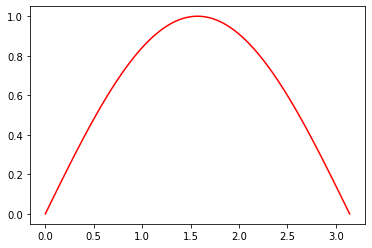

In [2]:
import numpy as np
# Generate array between 0 and pi
data = np.linspace(0, np.pi, 100)
goal = np.sin(data)
plt.plot(data, goal, "r")
plt.show()

Let's find the optimal parameters by creating our own Optimizer. You may want to pass own arguments to the class for usage in the objective. Just overwrite the `__init__` of the `Optimizer`. 
Depending on your use-case, you may want to pass `x0` and `bounds` as well. Some solvers don't require initial values. Boundaries are mostly required.

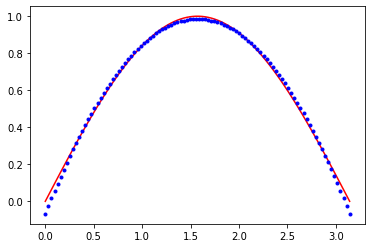

In [3]:
from ebcpy.optimization import Optimizer

class MyCustomOptimizer(Optimizer):

    def __init__(self, goal, data, **kwargs):
        super().__init__(**kwargs)
        self.goal = goal
        self.data = data
        
    def obj(self, xk, *args):
        # Calculate the quadratic formula:
        quadratic_func = xk[0] * self.data ** 2\
                            + xk[1] * self.data\
                            + xk[2]
        # Return the MAE of the quadratic function.
        return np.sum(np.abs(self.goal - quadratic_func))

mco = MyCustomOptimizer(goal=goal,
                        data=data,
                        bounds = [(-100, 100), (-100, 100), (-100, 100)]  # Specify bounds to the optimization
                        )

res = mco.optimize(framework="scipy_differential_evolution", method="best1bin")
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

In order to see the advantage of the optimizer class, see the solutions for different frameworks below

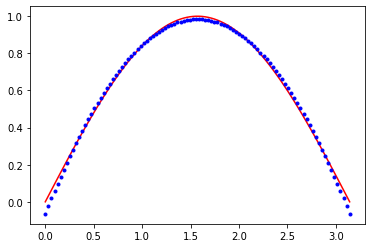

In [4]:
res = mco.optimize(framework="scipy_minimize", 
                   method="L-BFGS-B", 
                   x0=[0, 0, 0]  # L-BFGS-B method requires an initial guess.
                  )
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

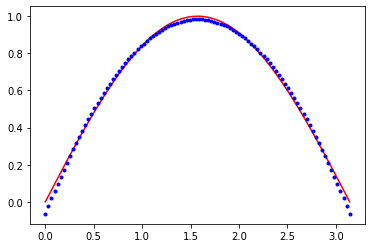

In [5]:
res = mco.optimize(framework="dlib_minimize", 
                   num_function_calls=1000  # Limit number of function calls 
                   )
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

In [6]:
res = mco.optimize(framework="pymoo")
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

TypeError: cannot unpack non-iterable method object

**If you have any questions or encounter bugs, please feel free to [raise an issue](https://git.rwth-aachen.de/EBC/EBC_all/Python/ebcpy/issues)! We hope this tutorial made the use case and usage of `ebcpy` clear to you. We also refer to the python examples in the examples folder. Here you can also test the objects within in the framework.**